In [1]:
import torch
import pandas as pd
import esm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import balanced_accuracy_score
from Bio import SeqIO
import numpy as np

In [69]:
EMB_PATH_PU = "./embeddings/pu"
EMB_PATH_NONPU = "./embeddings/nonpu"
EMB_UNKOWN = "./embeddings/unknown"

# Data Load


Open Non Core Pu file


In [2]:
with open("SET_PUs_NON_CORES (1).txt") as f:
    No_Pu = f.readlines()

for i in range(len(No_Pu)):
    No_Pu[i] = No_Pu[i].strip()

Open Fasta data


In [3]:
fasta_file = "DB_PU_NONPU_SEQ.fasta"
fasta_sequence = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        fasta_sequence.append(record)

Open Pu File


In [4]:
Pu = pd.read_table(
    "LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies (1)", sep="\t", header=None
)

In [5]:
data = []
for line in Pu[0]:
    liste = []

    line = line.split(" ")
    for element in line:
        if element != "":
            liste.append(element)
    data.append(liste)

In [6]:
CLASS = []
ARCHITECTURE = []
TOPOLOGY = []
NANOFOLD = []
FREQUENCY = []
PROTO_FOLD_PROTOTYPE = []
PU_FAMILY_MEMBERS_CATEGORY = []
for element in data[7:]:
    CLASS.append(element[0])
    ARCHITECTURE.append(element[1])
    TOPOLOGY.append(element[2])
    NANOFOLD.append(element[3])
    FREQUENCY.append(element[4])
    PROTO_FOLD_PROTOTYPE.append(element[5])
    PU_FAMILY_MEMBERS_CATEGORY.append(element[6:])

In [7]:
for i in range(len(PU_FAMILY_MEMBERS_CATEGORY)):
    PU_FAMILY_MEMBERS_CATEGORY[i][0] = PU_FAMILY_MEMBERS_CATEGORY[i][0].split(":")[1]

In [8]:
d = {
    "CLASS": CLASS,
    "ARCHITECTURE": ARCHITECTURE,
    "TOPOLOGY": TOPOLOGY,
    "NANOFOLD": NANOFOLD,
    "FREQUENCY": FREQUENCY,
    "PROTO_FOLD_PROTOTYPE": PROTO_FOLD_PROTOTYPE,
    "PU_FAMILY_MEMBERS_CATEGORY": PU_FAMILY_MEMBERS_CATEGORY,
}

In [9]:
Pu_families = pd.DataFrame(data=d)

In [10]:
Pu_families.head()

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,FREQUENCY,PROTO_FOLD_PROTOTYPE,PU_FAMILY_MEMBERS_CATEGORY
0,Alpha-beta,bab,bUaUb,35.g306,9,1MJNA_2_127_163,"[1U14A_2_1_37, 2WW8A_12_487_525, 2DZXA_4_82_11..."
1,All-alpha,a,a,30.g147,91,2EO5A_10_78_103,"[2EO5A_10_78_103, 3QVQA_7_118_144, 3V7NA_14_35..."
2,All-alpha,a,a,20.g594,5,1YBTA_1_16_34,"[3JSZA_14_357_376, 3A24A_10_525_542, 1YBTA_1_1..."
3,Alpha-beta,aba,aUbLa,35.g162,157,1YISA_10_258_288,"[3K7XA_10_267_294, 4G10A_4_105_133, 3C3RA_10_2..."
4,Alpha-beta,baba,bUaUbLa,45.g94,31,3ICSA_11_510_555,"[2HHGA_2_86_132, 3SNKA_1_1_48, 2UUUA_6_300_347..."


Set data labels


In [11]:
Sequence = []
Is_pu = []
file = []
for record in fasta_sequence:
    Sequence.append(str(record.seq))
    file_name = f'{record.id}_{record.description.split("|")[1].split(" ")[1].split(":")[1]}_{record.description.split("|")[2].split(" ")[1].split(":")[1]}_{record.description.split("|")[3].split(" ")[1].split(":")[1]}'
    file.append(file_name)
    if file_name in No_Pu:
        Is_pu.append(0)
    elif file_name in Pu_families["PROTO_FOLD_PROTOTYPE"].values:
        Is_pu.append(1)
    else:
        Is_pu.append(2)

In [12]:
d = {"Sequence": Sequence, "Is_pu": Is_pu, "file": file}

In [13]:
seq_data = pd.DataFrame(data=d)

In [14]:
seq_data.head()

,Sequence,Is_pu,file
0,DGERQFSTLKSTVEAIWAG,2,12ASA_10_122_140
1,AYIAKQRQISFVKSHFSRQLEERL,2,12ASA_10_1_24
2,IKATEAAVSEEFGLAP,2,12ASA_10_141_156
3,FLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLV,2,12ASA_10_157_196
4,GIGGKLSDGHRHDVRA,2,12ASA_10_197_212


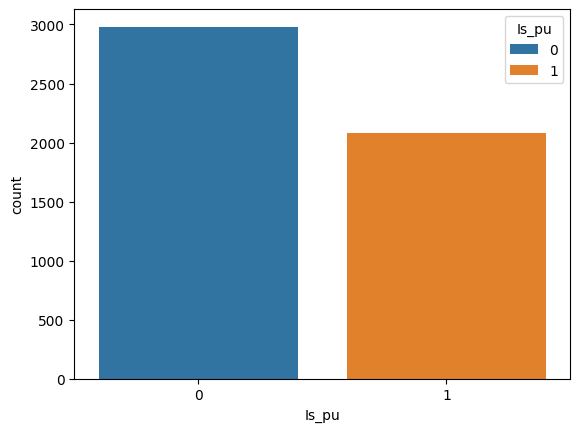

In [15]:
# Count on pu and non pu


sns.countplot(x="Is_pu", data=seq_data.loc[(seq_data["Is_pu"] != 2)], hue="Is_pu")
plt.show()

In [16]:
# count is_pu=2 and plot value using pandas
print(
    "unkown %d\npu %d\nnon-pu %d"
    % (
        seq_data.loc[(seq_data["Is_pu"] == 2)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 1)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 0)]["Is_pu"].count(),
    )
)

unkown 1051653
pu 2081
non-pu 2981


# Embedding


Data for embedding


In [36]:
pre_emb_pu = seq_data.loc[(seq_data["Is_pu"] == 1)][["Sequence", "file"]]
pre_emb_nonpu = seq_data.loc[(seq_data["Is_pu"] == 0)][["Sequence", "file"]]

Transformers


In [34]:
def embedding_preparation(pre_emb, EMB_PATH):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    for line in pre_emb.values:
        # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

        data = [(line[1], line[0])]

        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        # Extract per-residue representations (on CPU)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)

            torch.save(results, f"{EMB_PATH}/{line[1]}.pt")

In [37]:
embedding_preparation(pre_emb_pu, EMB_PATH_PU)
embedding_preparation(pre_emb_nonpu, EMB_PATH_NONPU)

# Dataset preparation


In [22]:
def padding(tensor, max_size):
    if tensor.numpy().shape[0] < max_size:
        padding = max_size - tensor.numpy().shape[0]
        tensor = tf.pad(tensor, ((0, padding), (0, 0)))
    return tensor

In [24]:
# List of all embeddings
def get_embedding_list(PATH, label, max_size):
    list_of_embeddings = []
    for filename in os.listdir(PATH):
        embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][
            33
        ][0]

        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings, [label] * len(list_of_embeddings)

In [108]:
batch_size = 200

In [26]:
pd_non_pu, label_non_pu = get_embedding_list(EMB_PATH_NONPU, 0, 62)
pd_pu, label_pu = get_embedding_list(EMB_PATH_PU, 1, 62)

In [27]:
embeddings = pd_non_pu + pd_pu
labels = label_non_pu + label_pu

In [28]:
print(embeddings[0])

tf.Tensor(
[[ 0.04803988  0.03526633 -0.01760992 ... -0.3153562   0.2511406
  -0.13878508]
 [-0.0099561   0.02071003  0.23420365 ...  0.29207087 -0.13407305
  -0.05613112]
 [-0.01918759  0.02974552  0.10829733 ...  0.11340906 -0.06686007
   0.13081023]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]], shape=(62, 1280), dtype=float32)


In [29]:
print(labels[0])

0


In [131]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

train_set, val_set, train_labels, val_labels = train_test_split(
    embeddings, labels, test_size=0.3,random_state=31,stratify=labels
)

In [31]:
def conv_data(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [32]:
def prep_data(train, lab, batch_size):
    tf_dataset = conv_data(train, lab)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
    return tf_dataset

In [132]:
tf_dataset = prep_data(train_set, train_labels, batch_size)
tf_val_dataset = prep_data(val_set, val_labels, batch_size)

# Tensorflow model:

Protein classification


In [133]:
# Compute class weights


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [45]:
model_tf = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(62, 1280)),
        tf.keras.layers.GRU(300, return_sequences=True, dropout=0.3),
        tf.keras.layers.GRU(200, return_sequences=True, dropout=0.5),
        tf.keras.layers.GRU(124, dropout=0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf.summary()
model_tf.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 62, 300)           1423800   
                                                                 
 gru_4 (GRU)                 (None, 62, 200)           301200    
                                                                 
 gru_5 (GRU)                 (None, 124)               121272    
                                                                 
 dense_1 (Dense)             (None, 2)                 250       
                                                                 
Total params: 1846522 (7.04 MB)
Trainable params: 1846522 (7.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [134]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_val_dataset,
    callbacks=callback,
    class_weight=class_weights,
    batch_size=batch_size,
)

Epoch 1/500
18/18 [==============================] - 13s 695ms/step - loss: 0.3921 - accuracy: 0.8160 - val_loss: 0.3755 - val_accuracy: 0.8354
Epoch 2/500
18/18 [==============================] - 12s 679ms/step - loss: 0.3731 - accuracy: 0.8219 - val_loss: 0.3626 - val_accuracy: 0.8341
Epoch 3/500
18/18 [==============================] - 13s 729ms/step - loss: 0.3600 - accuracy: 0.8318 - val_loss: 0.3671 - val_accuracy: 0.8295
Epoch 4/500
18/18 [==============================] - 13s 716ms/step - loss: 0.3599 - accuracy: 0.8264 - val_loss: 0.3640 - val_accuracy: 0.8282
Epoch 5/500
18/18 [==============================] - 12s 698ms/step - loss: 0.3569 - accuracy: 0.8326 - val_loss: 0.3737 - val_accuracy: 0.8315


In [37]:
def plot_history(history, metric):
    plt.plot(history.history[f"{metric}"])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.legend(["train", "test"], loc="upper left")
    plt.ylabel(f"{metric}")
    plt.xlabel("epoch")
    plt.show()

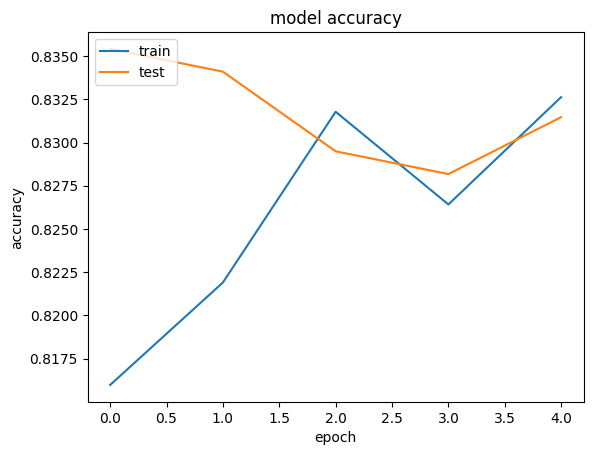

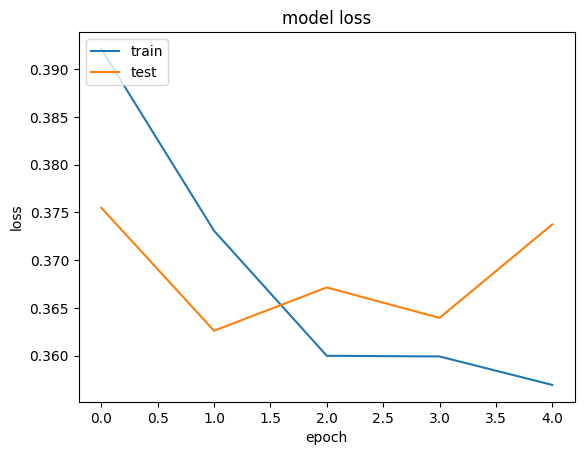

In [135]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")

8/8 [==============================] - 2s 242ms/step


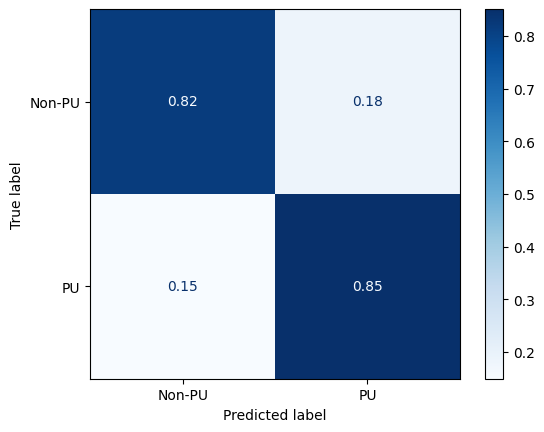

In [136]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf.predict(tf_val_dataset).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [137]:
# Compute balanced accuracy

print(
    "Balanced accuracy: %0.2f"
    % balanced_accuracy_score(
        val_labels, model_tf.predict(tf_val_dataset).argmax(axis=1)
    ),
)

8/8 [==============================] - 2s 231ms/step
Balanced accuracy: 0.83


In [141]:
def is_pu_from_file(PATH, filename):
    embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [142]:
def is_pu_from_seq(seq, name):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    # Prepare data
    data = [(name, seq)]

    batch_labels, batch_strs, batch_tokens = batch_converter(data)

    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    embedding_dict = results["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [143]:
is_pu_from_file(EMB_PATH_PU, "1A0CA_12_310_329.pt")

1/1 [==============================] - 0s 21ms/step
PU
pred =  1


In [144]:
is_pu_from_file(EMB_PATH_NONPU, "1A0TP_10_23_44.pt")

1/1 [==============================] - 0s 20ms/step
Non-PU
pred =  0


In [59]:
seq_data.loc[(seq_data["file"] == "12ASA_10_213_228")]

,Sequence,Is_pu,file
5,PDYDDWSTPSELGHAG,2,12ASA_10_213_228


In [140]:
is_pu_from_seq("PDYDDWSTPSELGHAG","12ASA_10_213_228")

1/1 [==============================] - 0s 67ms/step
Non-PU
pred =  0


UNKNOWN


In [ ]:
unknown = seq_data.loc[(seq_data["Is_pu"] == 2)][["Sequence", "file"]]

In [ ]:
embedding_preparation(unknown, EMB_UNKOWN)

In [70]:
is_pu_from_file(EMB_UNKOWN, "1A0CA_1_1_385.pt")

1/1 [==============================] - 0s 489ms/step
Non-PU
pred =  0


In [42]:
tensor_unknown = tf.convert_to_tensor(
    torch.load(EMB_UNKOWN + "/1A0CA_1_1_385.pt")["representations"][33][0]
)

In [43]:
set_unknown = tf.data.Dataset.from_tensor_slices(
    (tensor_unknown, [2] * len(tensor_unknown))
)
set_unknown = set_unknown.batch(128)
set_unknown = set_unknown.prefetch(tf.data.AUTOTUNE)

In [46]:
len(set_unknown)

4

famille PU MODEL


In [69]:
columns = [
    "CLASS",
    "ARCHITECTURE",
    "TOPOLOGY",
    "NANOFOLD",
    "PU_FAMILY_MEMBERS_CATEGORY",
    "PROTO_FOLD_PROTOTYPE",
]

In [70]:
data_category = Pu_families[columns]

In [71]:
data_category

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,PU_FAMILY_MEMBERS_CATEGORY,PROTO_FOLD_PROTOTYPE
0,Alpha-beta,bab,bUaUb,35.g306,"[1U14A_2_1_37, 2WW8A_12_487_525, 2DZXA_4_82_11...",1MJNA_2_127_163
1,All-alpha,a,a,30.g147,"[2EO5A_10_78_103, 3QVQA_7_118_144, 3V7NA_14_35...",2EO5A_10_78_103
2,All-alpha,a,a,20.g594,"[3JSZA_14_357_376, 3A24A_10_525_542, 1YBTA_1_1...",1YBTA_1_16_34
3,Alpha-beta,aba,aUbLa,35.g162,"[3K7XA_10_267_294, 4G10A_4_105_133, 3C3RA_10_2...",1YISA_10_258_288
4,Alpha-beta,baba,bUaUbLa,45.g94,"[2HHGA_2_86_132, 3SNKA_1_1_48, 2UUUA_6_300_347...",3ICSA_11_510_555
...,...,...,...,...,...,...
2856,All-alpha,aa,aLa,30.g286,"[3MVPA_7_17_45, 1SZHA_2_121_147, 1Q15A_10_463_...",1Q15A_10_463_491
2857,Alpha-beta,aba,aLbLa,30.g11,"[3LLKA_5_136_165, 3FRKA_10_339_365, 3TTGA_10_8...",1OKSA_1_1_30
2858,Alpha-beta,bbba,bUbUbUa,55.g137,"[3C5NA_1_177_231, 2ZW5A_4_54_108, 3F8KA_2_38_9...",3F8KA_2_38_92
2859,All-alpha,aa,aUa,35.g38,"[2FTZA_5_1_37, 2FNOA_2_91_132, 1VBIA_4_266_305...",1RRMA_7_184_219


In [76]:
data_category.isnull().sum()

CLASS                         0
ARCHITECTURE                  0
TOPOLOGY                      0
NANOFOLD                      0
PU_FAMILY_MEMBERS_CATEGORY    0
PROTO_FOLD_PROTOTYPE          0
dtype: int64

In [109]:
Xtrain, xtest, Ytrain, ytest = train_test_split(
    data_category.iloc[:, :-1], data_category["PROTO_FOLD_PROTOTYPE"], random_state=42
)

In [110]:
model_famille = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(128, activation="relu", input_shape=(Xtrain.shape[1],)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(4, activation="relu"),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)


model_famille.summary()


model_famille.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"],
)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               768       
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                                 
 dense_35 (Dense)            (None, 16)                528       
                                                                 
 dense_36 (Dense)            (None, 8)                 136       
                                                                 
 dense_37 (Dense)            (None, 4)                 36        
                                                                 
 dense_38 (Dense)            (None, 2)                

In [111]:
model_famille.fit(
    Xtrain, Ytrain, validation_data=(xtest, ytest), epochs=100, batch_size=32
)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list).

In [112]:
# pritin unique values in list contained in PU_family_members_category
dico = {}
for elment in data_category["PU_FAMILY_MEMBERS_CATEGORY"]:
    for pu_elemnt in elment:
        if pu_elemnt not in PU_FAMILY_MEMBERS_CATEGORY:
            dico[pu_elemnt] = 1

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,PU_FAMILY_MEMBERS_CATEGORY
2397,Alpha-beta,ba,bUa,30.g258,"[3P2HA_3_92_126, 2QIBA_5_60_92, 3K8TA_10_351_3..."
1405,Alpha-beta,aba,aLbUa,40.g35,"[2WK1A_4_156_195, 1OMOA_5_109_150, 1Y8QB_13_91..."
1801,Alpha-beta,abbb,aUbUbUb,45.g124,"[3P16A_3_327_375, 3C0UA_1_131_177, 3A1JC_3_76_..."
166,All-alpha,aa,aUa,50.g182,"[2R7HA_2_1_46, 3ODNA_10_46_91, 4GYTA_3_39_84, ..."
59,All-alpha,aa,aUa,40.g15,"[2XSEA_2_89_133, 3I28A_10_32_78, 3C8TA_10_340_..."
...,...,...,...,...,...
1638,All-alpha,a,a,25.g389,"[4ESWA_10_227_253, 3MJOA_10_113_137, 3F2BA_10_..."
1095,All-alpha,aa,aUa,20.g566,"[2W53A_3_88_110, 3AJMA_6_103_126, 3ELNA_5_1_23..."
1130,All-alpha,a,a,25.g323,"[1KHDA_10_81_104, 2GF9A_3_151_176, 1YDYA_10_14..."
1294,Alpha-beta,ba,bUa,30.g175,"[3GG9A_11_240_273, 2QTWB_10_115_146, 2EKLA_10_..."
